# LLM Evaluation for Classification Tasks

This notebook implements the full evaluation pipeline for the six identified classification tasks. The process is as follows:

1.  **Setup**: Install libraries and initialize the OpenAI API client.
2.  **Helper Functions**: Define core functions for making API calls and saving results. The API call function is designed to handle both modern Chat models (`gpt-4o`) and older Completion models (`gpt-5-pro`).
3.  **Task-by-Task Evaluation**: For each of the six classification files, a dedicated cell runs the full evaluation across all specified models (`gpt-3.5-turbo`, `gpt-4o`, `gpt-5-pro`).
4.  **Result Caching**: The results for each task are saved to a separate JSON file (e.g., `results_task_1.json`), preventing data loss and avoiding the need to re-run expensive API calls.
5.  **Final Analysis**: After all tasks are evaluated, a final cell aggregates the results from all saved files to produce a summary table and visualization, comparing the performance of each model across all tasks.

### 1. Environment Setup

In [ ]:
# %pip install openai python-dotenv scikit-learn matplotlib tqdm pandas
%pip install json

### 2. Imports, API Initialization, and Constants

In [1]:
import json
import os
import time
from openai import OpenAI
from dotenv import load_dotenv
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import random

# --- API and Model Configuration ---
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# The models we will compare
MODELS_TO_TEST = ["gpt-3.5-turbo", "gpt-4o"]

# The single prompt template we will use
JSON_INSTRUCTION = (
    "Your response MUST be a JSON object with a single key 'prediction' "
    "whose value is one of the following exact strings: {labels}."
)

# Ensure a directory for results exists
os.makedirs('results', exist_ok=True)

### 3. Core Helper Functions

In [2]:
def load_json_file(file_path):
    """Loads a JSON file safely."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

def save_results(results, file_path):
    """Saves a list of dictionaries to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)
    print(f"Successfully saved {len(results)} results to {file_path}")

def get_prompt(instruction_input, valid_labels):
    """Builds the single, simple prompt for the LLM."""
    labels_str = str(valid_labels)
    return f"{instruction_input}\n\n{JSON_INSTRUCTION.format(labels=labels_str)}"

def get_llm_prediction(client, model_name, prompt):
    """Calls the correct API endpoint based on the model and gets a prediction."""
    retries = 3
    delay = 5  # Start with a 5-second delay for robustness

    for attempt in range(retries):
        try:
            content = None
            if model_name == "gpt-5-pro":
                # Use the older Completions API for this model
                response = client.completions.create(
                    model=model_name,
                    prompt=prompt,
                    max_tokens=150,
                    temperature=0
                )
                content = response.choices[0].text
            else:
                # Use the modern Chat Completions API for other models
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    response_format={"type": "json_object"},
                    temperature=0
                )
                content = response.choices[0].message.content
            
            # Parse the content to extract the prediction
            # Find the start of the JSON object
            json_start_index = content.find('{')
            if json_start_index == -1:
                return "parsing_error"
            
            json_content = content[json_start_index:]
            prediction_json = json.loads(json_content)
            return prediction_json.get("prediction", "parsing_error")
        
        except Exception as e:
            print(f"API Error ({model_name}): {e}. Retrying... (Attempt {attempt + 1}/{retries})")
            time.sleep(delay)
            delay *= 2  # Exponential backoff
            
    return "api_error" # Failed after all retries

### 4. Main Evaluation Function

This function encapsulates the logic for running an evaluation on a given data file. It handles loading data, iterating through models and instructions, calling the LLM (while managing a simple file-based cache to resume progress), and saving the final results.

In [10]:
def run_evaluation(client, data_file_path, valid_labels, unique_id_keys, sample_percentage, label_map=None):
    """
    Runs the full evaluation pipeline for a single data file.
    - sample_count: If provided, runs on a random sample of this many instructions.
    - label_map: An optional dictionary to map messy instruction_outputs to clean labels.
    """
    
    task_name = os.path.basename(data_file_path).split('.')[0]
    results_path = f"results/results_{task_name}.json"
    
    print(f"\n{'='*20} Starting Evaluation for: {task_name} {'='*20}")
    
    # --- Load all instructions from the data file ---
    all_instructions = load_json_file(data_file_path)
    if not all_instructions:
        return

    sample_size = int(len(all_instructions) * sample_percentage)
    # Randomly sample 10% of the instructions. 
    random.seed(42)
    instructions = random.sample(all_instructions, sample_size)
    print(f"Original dataset size: {len(all_instructions)}. Using a random sample of {len(instructions)} instructions (10%).")
    
    # --- Load existing results (for resuming) ---
    all_results = []
    processed_keys = set()
    if os.path.exists(results_path):
        all_results = load_json_file(results_path)
        for res in all_results:
            key_tuple = (res['model_name'],) + tuple(res[k] for k in unique_id_keys)
            processed_keys.add(key_tuple)
        print(f"Loaded {len(all_results)} existing results. Resuming...")

    api_calls_made = 0

    # --- Main evaluation loop ---
    for model_name in MODELS_TO_TEST:
        print(f"\n--- Processing Model: {model_name} ---")
        
        for instruction in tqdm(instructions, desc=f"Model: {model_name}"):
            id_values = [instruction.get(k) for k in unique_id_keys]
            current_key = (model_name,) + tuple(id_values)

            if current_key in processed_keys:
                continue
            
            prompt = get_prompt(instruction['instruction_input'], valid_labels)
            prediction = get_llm_prediction(client, model_name, prompt)
            api_calls_made += 1
            
            # --- START: New Label Mapping Logic ---
            true_label_raw = instruction['instruction_output']
            true_label = true_label_raw # Default if no map
            
            if label_map:
                # Find the correct simple label
                mapped_label = "Other/Unknown" # default
                for key_prefix, simple_label in label_map.items():
                    if true_label_raw.startswith(key_prefix):
                        mapped_label = simple_label
                        break
                true_label = mapped_label
            # --- END: New Label Mapping Logic ---
            
            result_record = {
                "model_name": model_name,
                "full_prompt_sent": prompt,
                "llm_prediction": prediction,
                "true_label": true_label,
                "is_correct": prediction == true_label,
                "timestamp": time.time()
            }
            for key, value in zip(unique_id_keys, id_values):
                result_record[key] = value
                
            all_results.append(result_record)
            processed_keys.add(current_key)
            
            if len(all_results) % 100 == 0:
                save_results(all_results, results_path)

    save_results(all_results, results_path)
    print(f"\nTotal new API calls made in this run: {api_calls_made}")
    print(f"\n{'='*20} Evaluation COMPLETE for: {task_name} {'='*20}")

### 5. Evaluation: Task 1 - Preference Simulation

In [11]:
# --- Config for this file ---
DATA_FILE_PATH_1 = 'data/task_1_preference_simulation 1.json'
VALID_LABELS_1 = ["Strongly Recommend", "Recommend", "Neutral", "Do Not Recommend"]
UNIQUE_ID_KEYS_1 = ['user_id', 'target_recipe_id']
sample_percentage = 0.05
# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_1, VALID_LABELS_1, UNIQUE_ID_KEYS_1, sample_percentage)


==================== Starting Evaluation for: task_1_preference_simulation 1 ====================
Original dataset size: 85399. Using a random sample of 4269 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/4269 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_1_preference_simulation 1.json
Successfully saved 200 results to results/results_task_1_preference_simulation 1.json
Successfully saved 300 results to results/results_task_1_preference_simulation 1.json
Successfully saved 400 results to results/results_task_1_preference_simulation 1.json
Successfully saved 500 results to results/results_task_1_preference_simulation 1.json
Successfully saved 600 results to results/results_task_1_preference_simulation 1.json
Successfully saved 700 results to results/results_task_1_preference_simulation 1.json
Successfully saved 800 results to results/results_task_1_preference_simulation 1.json
Successfully saved 900 results to results/results_task_1_preference_simulation 1.json
Successfully saved 1000 results to results/results_task_1_preference_simulation 1.json
Successfully saved 1100 results to results/results_task_1_preference_simulation 1.json
Successfully saved 1200 results to results/results_t

Model: gpt-4o:   0%|          | 0/4269 [00:00<?, ?it/s]

Successfully saved 4300 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4400 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4500 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4600 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4700 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4800 results to results/results_task_1_preference_simulation 1.json
Successfully saved 4900 results to results/results_task_1_preference_simulation 1.json
Successfully saved 5000 results to results/results_task_1_preference_simulation 1.json
Successfully saved 5100 results to results/results_task_1_preference_simulation 1.json
Successfully saved 5200 results to results/results_task_1_preference_simulation 1.json
Successfully saved 5300 results to results/results_task_1_preference_simulation 1.json
Successfully saved 5400 results to results/

Model: gpt-5-pro:   0%|          | 0/4269 [00:00<?, ?it/s]

API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 1/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 2/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 3/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 1/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.'

KeyboardInterrupt: 

### 6. Evaluation: Task 3 - Tag-Based Preference

In [13]:
# --- Config for this file ---
DATA_FILE_PATH_3 = 'data/task_3_tag_based_preference 1.json'
VALID_LABELS_3 = ["Strongly Recommend", "Recommend", "Neutral", "Do Not Recommend"]
UNIQUE_ID_KEYS_3 = ['user_id', 'target_recipe_id']
sample_percentage = 0.1

# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_3, VALID_LABELS_3, UNIQUE_ID_KEYS_3, sample_percentage)


==================== Starting Evaluation for: task_3_tag_based_preference 1 ====================
Original dataset size: 16449. Using a random sample of 1644 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/1644 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 200 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 300 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 400 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 500 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 600 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 700 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 800 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 900 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 1000 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 1100 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 1200 results to results/results_task_3_tag_b

Model: gpt-4o:   0%|          | 0/1644 [00:00<?, ?it/s]

Successfully saved 1700 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 1800 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 1900 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2000 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2100 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2200 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2300 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2400 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2500 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2600 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2700 results to results/results_task_3_tag_based_preference 1.json
Successfully saved 2800 results to results/results_tas

Model: gpt-5-pro:   0%|          | 0/1644 [00:00<?, ?it/s]

API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 1/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 2/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 3/3)
API Error (gpt-5-pro): Error code: 404 - {'error': {'message': 'This model is not supported in the v1/completions endpoint.', 'type': 'invalid_request_error', 'param': 'model', 'code': None}}. Retrying... (Attempt 1/3)


KeyboardInterrupt: 

### 7. Evaluation: Task 8 - Flavor Memory

In [17]:
# --- Config for this file ---
DATA_FILE_PATH_8 = 'data/task_8_flavor_memory 1.json'
VALID_LABELS_8 = ["Strongly Recommend", "Recommend", "Neutral", "Do Not Recommend"]
UNIQUE_ID_KEYS_8 = ['user_id', 'target_recipe_id']
sample_percentage = 0.1

# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_8, VALID_LABELS_8, UNIQUE_ID_KEYS_8, sample_percentage = 0.1)


==================== Starting Evaluation for: task_8_flavor_memory 1 ====================
Original dataset size: 23415. Using a random sample of 2341 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/2341 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_8_flavor_memory 1.json
Successfully saved 200 results to results/results_task_8_flavor_memory 1.json
Successfully saved 300 results to results/results_task_8_flavor_memory 1.json
Successfully saved 400 results to results/results_task_8_flavor_memory 1.json
Successfully saved 500 results to results/results_task_8_flavor_memory 1.json
Successfully saved 600 results to results/results_task_8_flavor_memory 1.json
Successfully saved 700 results to results/results_task_8_flavor_memory 1.json
Successfully saved 800 results to results/results_task_8_flavor_memory 1.json
Successfully saved 900 results to results/results_task_8_flavor_memory 1.json
Successfully saved 1000 results to results/results_task_8_flavor_memory 1.json
Successfully saved 1100 results to results/results_task_8_flavor_memory 1.json
Successfully saved 1200 results to results/results_task_8_flavor_memory 1.json
Successfully saved 1300 results to results/results_task_8_fla

Model: gpt-4o:   0%|          | 0/2341 [00:00<?, ?it/s]

Successfully saved 2400 results to results/results_task_8_flavor_memory 1.json
Successfully saved 2500 results to results/results_task_8_flavor_memory 1.json
Successfully saved 2600 results to results/results_task_8_flavor_memory 1.json
Successfully saved 2700 results to results/results_task_8_flavor_memory 1.json
Successfully saved 2800 results to results/results_task_8_flavor_memory 1.json
Successfully saved 2900 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3000 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3100 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3200 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3300 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3400 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3500 results to results/results_task_8_flavor_memory 1.json
Successfully saved 3600 results to results/results_t

### 8. Evaluation: Task 9 - Health Profile

In [5]:
# --- Config for this file ---
DATA_FILE_PATH_9 = 'data/task_9_health_profile 3.json'
VALID_LABELS_9 = ["Strongly Recommend", "Recommend", "Neutral", "Do Not Recommend"]
UNIQUE_ID_KEYS_9 = ['user_id', 'target_recipe_id']
sample_percentage = 0.1


# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_9, VALID_LABELS_9, UNIQUE_ID_KEYS_9, sample_percentage)


==================== Starting Evaluation for: task_9_health_profile 3 ====================
Original dataset size: 12993. Using a random sample of 1299 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/1299 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_9_health_profile 3.json
Successfully saved 200 results to results/results_task_9_health_profile 3.json
Successfully saved 300 results to results/results_task_9_health_profile 3.json
Successfully saved 400 results to results/results_task_9_health_profile 3.json
Successfully saved 500 results to results/results_task_9_health_profile 3.json
Successfully saved 600 results to results/results_task_9_health_profile 3.json
Successfully saved 700 results to results/results_task_9_health_profile 3.json
Successfully saved 800 results to results/results_task_9_health_profile 3.json
Successfully saved 900 results to results/results_task_9_health_profile 3.json
Successfully saved 1000 results to results/results_task_9_health_profile 3.json
Successfully saved 1100 results to results/results_task_9_health_profile 3.json
Successfully saved 1200 results to results/results_task_9_health_profile 3.json

--- Processing Model: gpt-4o ---


Model: gpt-4o:   0%|          | 0/1299 [00:00<?, ?it/s]

Successfully saved 1300 results to results/results_task_9_health_profile 3.json
Successfully saved 1400 results to results/results_task_9_health_profile 3.json
Successfully saved 1500 results to results/results_task_9_health_profile 3.json
Successfully saved 1600 results to results/results_task_9_health_profile 3.json
Successfully saved 1700 results to results/results_task_9_health_profile 3.json
Successfully saved 1800 results to results/results_task_9_health_profile 3.json
Successfully saved 1900 results to results/results_task_9_health_profile 3.json
Successfully saved 2000 results to results/results_task_9_health_profile 3.json
Successfully saved 2100 results to results/results_task_9_health_profile 3.json
Successfully saved 2200 results to results/results_task_9_health_profile 3.json
Successfully saved 2300 results to results/results_task_9_health_profile 3.json
Successfully saved 2400 results to results/results_task_9_health_profile 3.json
Successfully saved 2500 results to resul

### 9. Evaluation: Task 5 - Session Drift

In [6]:
# --- Config for this file ---
DATA_FILE_PATH_5 = 'data/task_5_session_drift 3.json'
VALID_LABELS_5 = ["Positive", "Neutral", "Negative"]
UNIQUE_ID_KEYS_5 = ['user_id', 'target_recipe_id']
sample_percentage = 0.03

# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_5, VALID_LABELS_5, UNIQUE_ID_KEYS_5, sample_percentage)


==================== Starting Evaluation for: task_5_session_drift 3 ====================
Original dataset size: 100000. Using a random sample of 3000 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/3000 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_5_session_drift 3.json
Successfully saved 200 results to results/results_task_5_session_drift 3.json
Successfully saved 300 results to results/results_task_5_session_drift 3.json
Successfully saved 400 results to results/results_task_5_session_drift 3.json
Successfully saved 500 results to results/results_task_5_session_drift 3.json
Successfully saved 600 results to results/results_task_5_session_drift 3.json
Successfully saved 700 results to results/results_task_5_session_drift 3.json
Successfully saved 800 results to results/results_task_5_session_drift 3.json
Successfully saved 900 results to results/results_task_5_session_drift 3.json
Successfully saved 1000 results to results/results_task_5_session_drift 3.json
Successfully saved 1100 results to results/results_task_5_session_drift 3.json
Successfully saved 1200 results to results/results_task_5_session_drift 3.json
Successfully saved 1300 results to results/results_task_5_ses

Model: gpt-4o:   0%|          | 0/3000 [00:00<?, ?it/s]

Successfully saved 3000 results to results/results_task_5_session_drift 3.json
Successfully saved 3100 results to results/results_task_5_session_drift 3.json
Successfully saved 3200 results to results/results_task_5_session_drift 3.json
Successfully saved 3300 results to results/results_task_5_session_drift 3.json
Successfully saved 3400 results to results/results_task_5_session_drift 3.json
Successfully saved 3500 results to results/results_task_5_session_drift 3.json
Successfully saved 3600 results to results/results_task_5_session_drift 3.json
Successfully saved 3700 results to results/results_task_5_session_drift 3.json
Successfully saved 3800 results to results/results_task_5_session_drift 3.json
Successfully saved 3900 results to results/results_task_5_session_drift 3.json
Successfully saved 4000 results to results/results_task_5_session_drift 3.json
Successfully saved 4100 results to results/results_task_5_session_drift 3.json
Successfully saved 4200 results to results/results_t

### 10. Evaluation: Task 6 - Repetition vs. Exploration

In [19]:
# --- Config for this file ---
DATA_FILE_PATH_6 = 'data/task_6_repetition_exploration 1.json'
VALID_LABELS_6 = ["Repetition", "Exploration"]
UNIQUE_ID_KEYS_6 = ['user_id', 'target_recipe_id']
sample_percentage = 0.03

# --- Run Evaluation ---
run_evaluation(client, DATA_FILE_PATH_6, VALID_LABELS_6, UNIQUE_ID_KEYS_6, sample_percentage)


==================== Starting Evaluation for: task_6_repetition_exploration 1 ====================
Original dataset size: 100000. Using a random sample of 3000 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/3000 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 200 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 300 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 400 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 500 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 600 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 700 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 800 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 900 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 1000 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 1100 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 1200 results to result

Model: gpt-4o:   0%|          | 0/3000 [00:00<?, ?it/s]

Successfully saved 3100 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3200 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3300 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3400 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3500 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3600 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3700 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3800 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 3900 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 4000 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 4100 results to results/results_task_6_repetition_exploration 1.json
Successfully saved 4200 results 

### 11. Evaluation: Task 10 - Health Tradeoff

In [11]:
# --- Config for this file ---
DATA_FILE_PATH_10 = 'data/task_10_health_tradeoff 3.json'
# These are the *clean* labels we will prompt the LLM for
VALID_LABELS_10 = ["Recipe A", "Recipe B", "Both rated equally"]
# This map converts the *messy* instruction_output into our clean labels
LABEL_MAP_10 = {
    "Recipe A": "Recipe A",
    "Recipe B": "Recipe B",
    "Both rated equally": "Both rated equally"
}
UNIQUE_ID_KEYS_10 = ['user_id', 'target_recipe_id']

sample_percentage = 0.1

# --- Run Evaluation ---
# We pass in the label_map and a sample_count
run_evaluation(client, DATA_FILE_PATH_10, VALID_LABELS_10, UNIQUE_ID_KEYS_10, sample_percentage, label_map=LABEL_MAP_10)


==================== Starting Evaluation for: task_10_health_tradeoff 3 ====================
Original dataset size: 14429. Using a random sample of 1442 instructions (10%).

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo:   0%|          | 0/1442 [00:00<?, ?it/s]

Successfully saved 100 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 200 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 300 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 400 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 500 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 600 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 700 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 800 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 900 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1000 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1100 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1200 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1300 r

Model: gpt-4o:   0%|          | 0/1442 [00:00<?, ?it/s]

Successfully saved 1500 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1600 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1700 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1800 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 1900 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2000 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2100 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2200 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2300 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2400 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2500 results to results/results_task_10_health_tradeoff 3.json
Successfully saved 2600 results to results/results_task_10_health_tradeoff 3.json
Successfully sav

### 12. Final Analysis

After all evaluation cells have been run, this final section loads all the generated result files into a single pandas DataFrame. It then calculates the overall accuracy and weighted F1-score for each model on each task, presenting a final summary table and a bar chart for easy comparison.

Loaded a total of 33724 predictions from 7 result files.


--- 🚀 Final Performance Summary (Weighted F1-Score) ---
| task_name                       |   gpt-3.5-turbo |   gpt-4o |
|:--------------------------------|----------------:|---------:|
| task_10_health_tradeoff 3       |          0.1904 |   0.3031 |
| task_1_preference_simulation 1  |          0.3784 |   0.3754 |
| task_3_tag_based_preference 1   |          0.1175 |   0.1030 |
| task_5_session_drift 3          |          0.4159 |   0.7616 |
| task_6_repetition_exploration 1 |          0.4778 |   0.5756 |
| task_8_flavor_memory 1          |          0.1889 |   0.2699 |
| task_9_health_profile 3         |          0.2908 |   0.0829 |


--- 🚀 Final Performance Summary (Accuracy) ---
| task_name                       |   gpt-3.5-turbo |   gpt-4o |
|:--------------------------------|----------------:|---------:|
| task_10_health_tradeoff 3       |          0.3044 |   0.3814 |
| task_1_preference_simulation 1  |          0.3298 |   

C:\Users\amollaza24\AppData\Local\Temp\ipykernel_3628\3838677675.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = full_df.groupby(['task_name', 'model_name']).apply(lambda x: pd.Series({


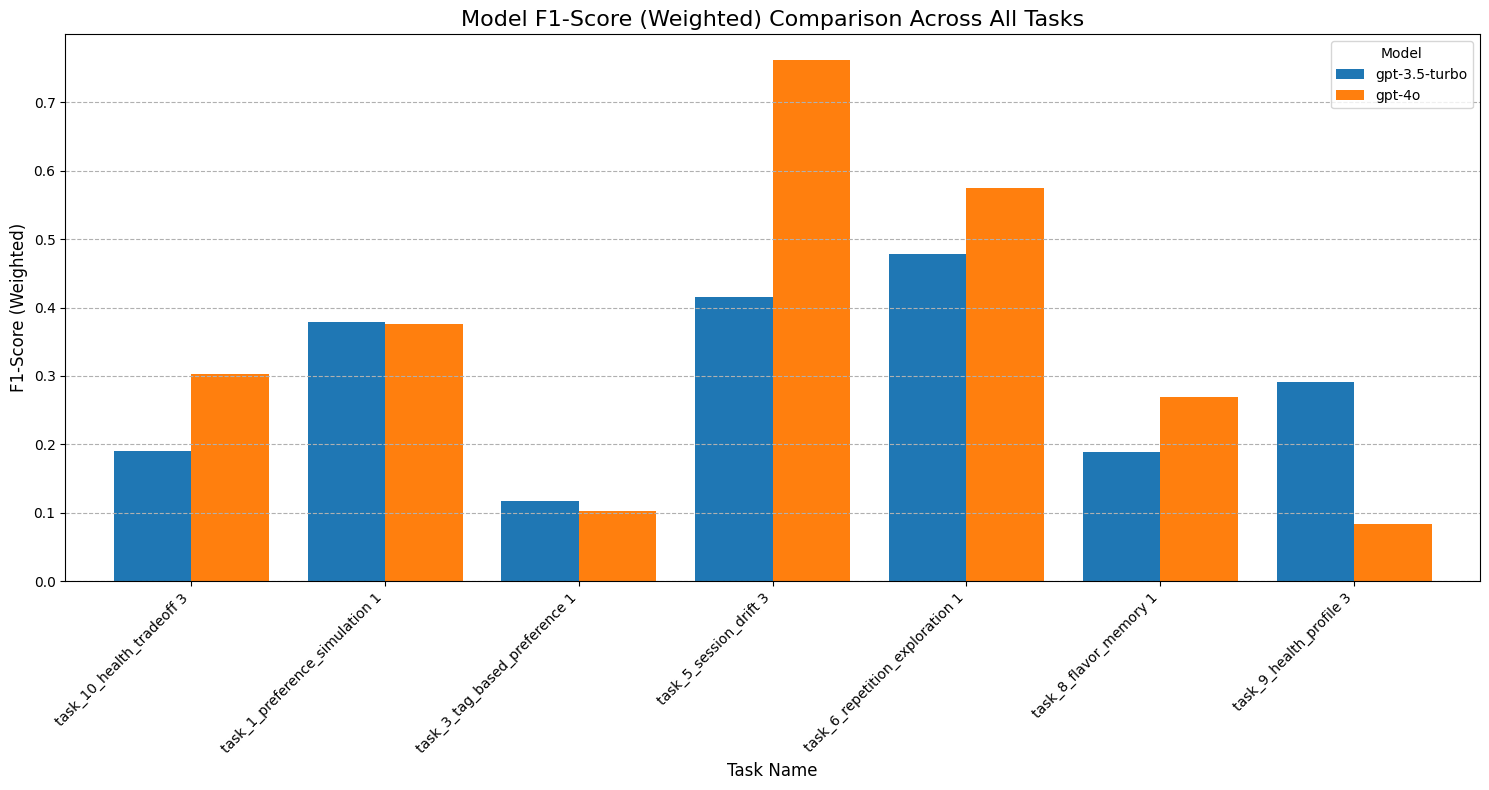

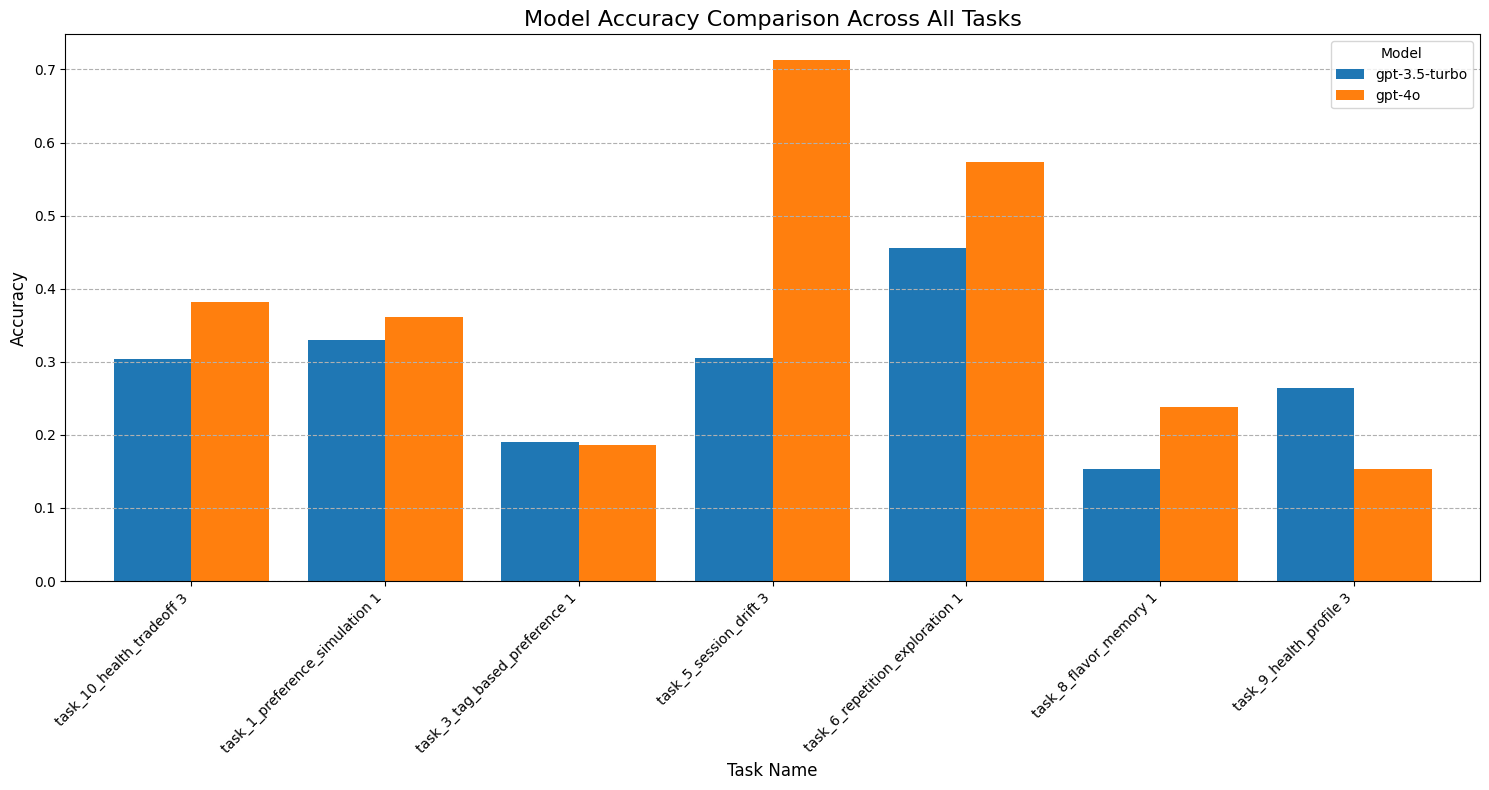

In [12]:
# --- Load all result files ---
results_dir = 'results'
all_results_df = []
for filename in os.listdir(results_dir):
    if filename.startswith('results_task_') and filename.endswith('.json'):
        # --- Load all classification tasks, including task_10 ---
        if any(task_num in filename for task_num in ['task_1', 'task_3', 'task_8', 'task_9', 'task_5', 'task_6', 'task_10']):
            task_name = filename.replace('results_', '').replace('.json', '')
            df = pd.read_json(os.path.join(results_dir, filename))
            df['task_name'] = task_name
            all_results_df.append(df)

if not all_results_df:
    print("No result files found. Please run the evaluation cells first.")
else:
    full_df = pd.concat(all_results_df, ignore_index=True)
    print(f"Loaded a total of {len(full_df)} predictions from {len(all_results_df)} result files.")

    # --- Calculate metrics for each group ---
    summary = full_df.groupby(['task_name', 'model_name']).apply(lambda x: pd.Series({
        'accuracy': accuracy_score(x['true_label'], x['llm_prediction']),
        'f1_score_weighted': f1_score(x['true_label'], x['llm_prediction'], average='weighted', zero_division=0)
    })).reset_index()

    # --- Display Summary Tables ---
    print("\n\n--- 🚀 Final Performance Summary (Weighted F1-Score) ---")
    summary_pivot_f1 = summary.pivot(index='task_name', columns='model_name', values='f1_score_weighted')
    print(summary_pivot_f1.to_markdown(floatfmt=".4f"))

    print("\n\n--- 🚀 Final Performance Summary (Accuracy) ---")
    summary_pivot_acc = summary.pivot(index='task_name', columns='model_name', values='accuracy')
    print(summary_pivot_acc.to_markdown(floatfmt=".4f"))
    
    # --- Display Visualization 1: F1-Score ---
    summary_pivot_f1.plot(kind='bar', figsize=(15, 8), width=0.8)
    plt.title('Model F1-Score (Weighted) Comparison Across All Tasks', fontsize=16)
    plt.ylabel('F1-Score (Weighted)', fontsize=12)
    plt.xlabel('Task Name', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show() # Show the first plot

    # --- START: New Plot for Accuracy ---
    
    # --- Display Visualization 2: Accuracy ---
    summary_pivot_acc.plot(kind='bar', figsize=(15, 8), width=0.8)
    plt.title('Model Accuracy Comparison Across All Tasks', fontsize=16)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Task Name', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show() # Show the second plot
    
    # --- END: New Plot for Accuracy ---